In [1]:
import pandas as pd
import re
import nltk
import seaborn as sns
import text2emotion as te
from afinn import Afinn
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from concurrent.futures import ThreadPoolExecutor
from sklearn.decomposition import LatentDirichletAllocation
from summa import summarizer
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import warnings

#nltk.download('sentiwordnet')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('vader_lexicon')

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data cleaning and normalization

In [2]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize the text
    words = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Initialize stemmer and lemmatizer
    ps = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    # Apply stemming and then lemmatization
    words = [ps.stem(word) for word in words]
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

In [3]:
df = pd.read_csv('techcrunch_articles_mechanicalsoup.csv')
df.head()

,title,url,content
0,"AT&T technician Mark Klein, who exposed secret...",https://techcrunch.com/2025/03/14/att-technici...,Latest AI Amazon Apps Biotech & Health Climate...
1,Vento rolls out new €75M fund for Italian foun...,https://techcrunch.com/2025/03/12/vento-hopes-...,Latest AI Amazon Apps Biotech & Health Climate...
2,UK’s secret iCloud backdoor order triggers civ...,https://techcrunch.com/2025/03/14/uks-secret-i...,Latest AI Amazon Apps Biotech & Health Climate...
3,"Elon Musk’s AI company, xAI, acquires 1 millio...",https://techcrunch.com/2025/03/07/elon-musks-a...,Latest AI Amazon Apps Biotech & Health Climate...
4,Bluesky users debate plans around user data an...,https://techcrunch.com/2025/03/15/bluesky-user...,Latest AI Amazon Apps Biotech & Health Climate...


In [4]:
df['cleaned_content'] = df['content'].apply(clean_text)
df.head(4)

,title,url,content,cleaned_content
0,"AT&T technician Mark Klein, who exposed secret...",https://techcrunch.com/2025/03/14/att-technici...,Latest AI Amazon Apps Biotech & Health Climate...,latest ai amazon app biotech health climat clo...
1,Vento rolls out new €75M fund for Italian foun...,https://techcrunch.com/2025/03/12/vento-hopes-...,Latest AI Amazon Apps Biotech & Health Climate...,latest ai amazon app biotech health climat clo...
2,UK’s secret iCloud backdoor order triggers civ...,https://techcrunch.com/2025/03/14/uks-secret-i...,Latest AI Amazon Apps Biotech & Health Climate...,latest ai amazon app biotech health climat clo...
3,"Elon Musk’s AI company, xAI, acquires 1 millio...",https://techcrunch.com/2025/03/07/elon-musks-a...,Latest AI Amazon Apps Biotech & Health Climate...,latest ai amazon app biotech health climat clo...


## CountVectorizer and TfidfVectorizer

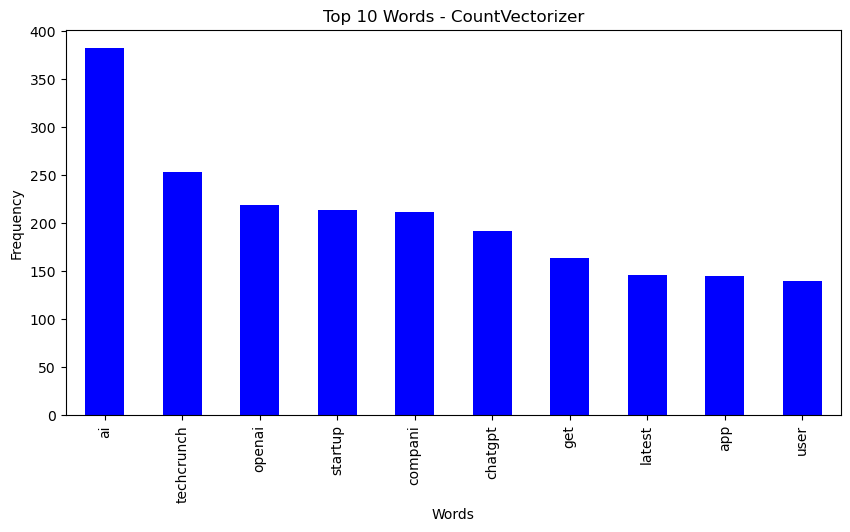

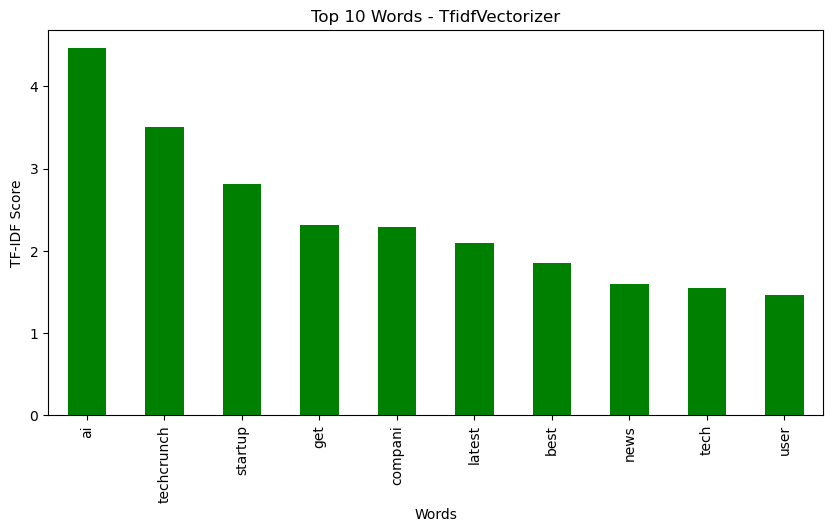

In [5]:
# Apply CountVectorizer
count_vectorizer = CountVectorizer()
count_matrix = count_vectorizer.fit_transform(df['cleaned_content'])
count_df = pd.DataFrame(count_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())

# Apply TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_content'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Plot CountVectorizer top words
plt.figure(figsize=(10,5))
count_df.sum().nlargest(10).plot(kind='bar', color='blue')
plt.title("Top 10 Words - CountVectorizer")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

# Plot TfidfVectorizer top words
plt.figure(figsize=(10,5))
tfidf_df.sum().nlargest(10).plot(kind='bar', color='green')
plt.title("Top 10 Words - TfidfVectorizer")
plt.xlabel("Words")
plt.ylabel("TF-IDF Score")
plt.show()

## Summarise

In [6]:
def clean_text(text):
    return text.lower()

df['cleaned_content'] = df['content'].apply(clean_text)

# Extractive Summarization using Summa
df['summary'] = df['cleaned_content'].apply(lambda x: summarizer.summarize(x, ratio=0.1))

# Calculate TF-IDF Scores for Topic Relevance
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['cleaned_content'])

# Apply LDA Topic Modeling
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(tfidf_matrix)

# Calculate Importance Score based on Topic Relevance (Example: Sum of TF-IDF scores of key words)
df['importance_score'] = df['cleaned_content'].apply(lambda x: sum([tfidf_matrix[0, idx] for idx in vectorizer.transform([x]).indices]))

# Sentiment Analysis for Emotional Relevance
df['sentiment_score'] = df['cleaned_content'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Normalize Importance Score
df['normalized_importance'] = (df['importance_score'] - df['importance_score'].min()) / (df['importance_score'].max() - df['importance_score'].min())

# Display Summary and Importance Score for each page
df[['summary', 'importance_score', 'normalized_importance']].head()

,summary,importance_score,normalized_importance
0,latest ai amazon apps biotech & health climate...,9.167810,1.000000
1,latest ai amazon apps biotech & health climate...,2.091631,0.016310
2,latest ai amazon apps biotech & health climate...,2.301755,0.045520
3,latest ai amazon apps biotech & health climate...,2.050269,0.010560
4,latest ai amazon apps biotech & health climate...,2.356263,0.053098


## Sentiment Analysis using Afinn, TexrBlob and Vader

In [7]:
# Apply AFINN Sentiment Analysis
afinn = Afinn()
df['afinn_score'] = df['cleaned_content'].apply(lambda x: afinn.score(x))
df['afinn_category'] = df['afinn_score'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

# Apply VADER Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()
df['vader_score'] = df['cleaned_content'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['vader_category'] = df['vader_score'].apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral'))

# Apply TextBlob Sentiment Analysis
df['textblob_score'] = df['cleaned_content'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['textblob_category'] = df['textblob_score'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

## SentiWordNet (WordNet-Based Sentiment)

In [8]:
def get_sentiment_score(text):
    words = word_tokenize(text)
    pos_score, neg_score = 0, 0
    for word in words:
        synsets = wordnet.synsets(word)
        if synsets:
            swn_synset = swn.senti_synset(synsets[0].name())
            pos_score += swn_synset.pos_score()
            neg_score += swn_synset.neg_score()
    
    return pos_score - neg_score

df['sentiwordnet_score'] = df['cleaned_content'].apply(get_sentiment_score)

df['sentiwordnet_category'] = df['sentiwordnet_score'].apply(
    lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral')
)

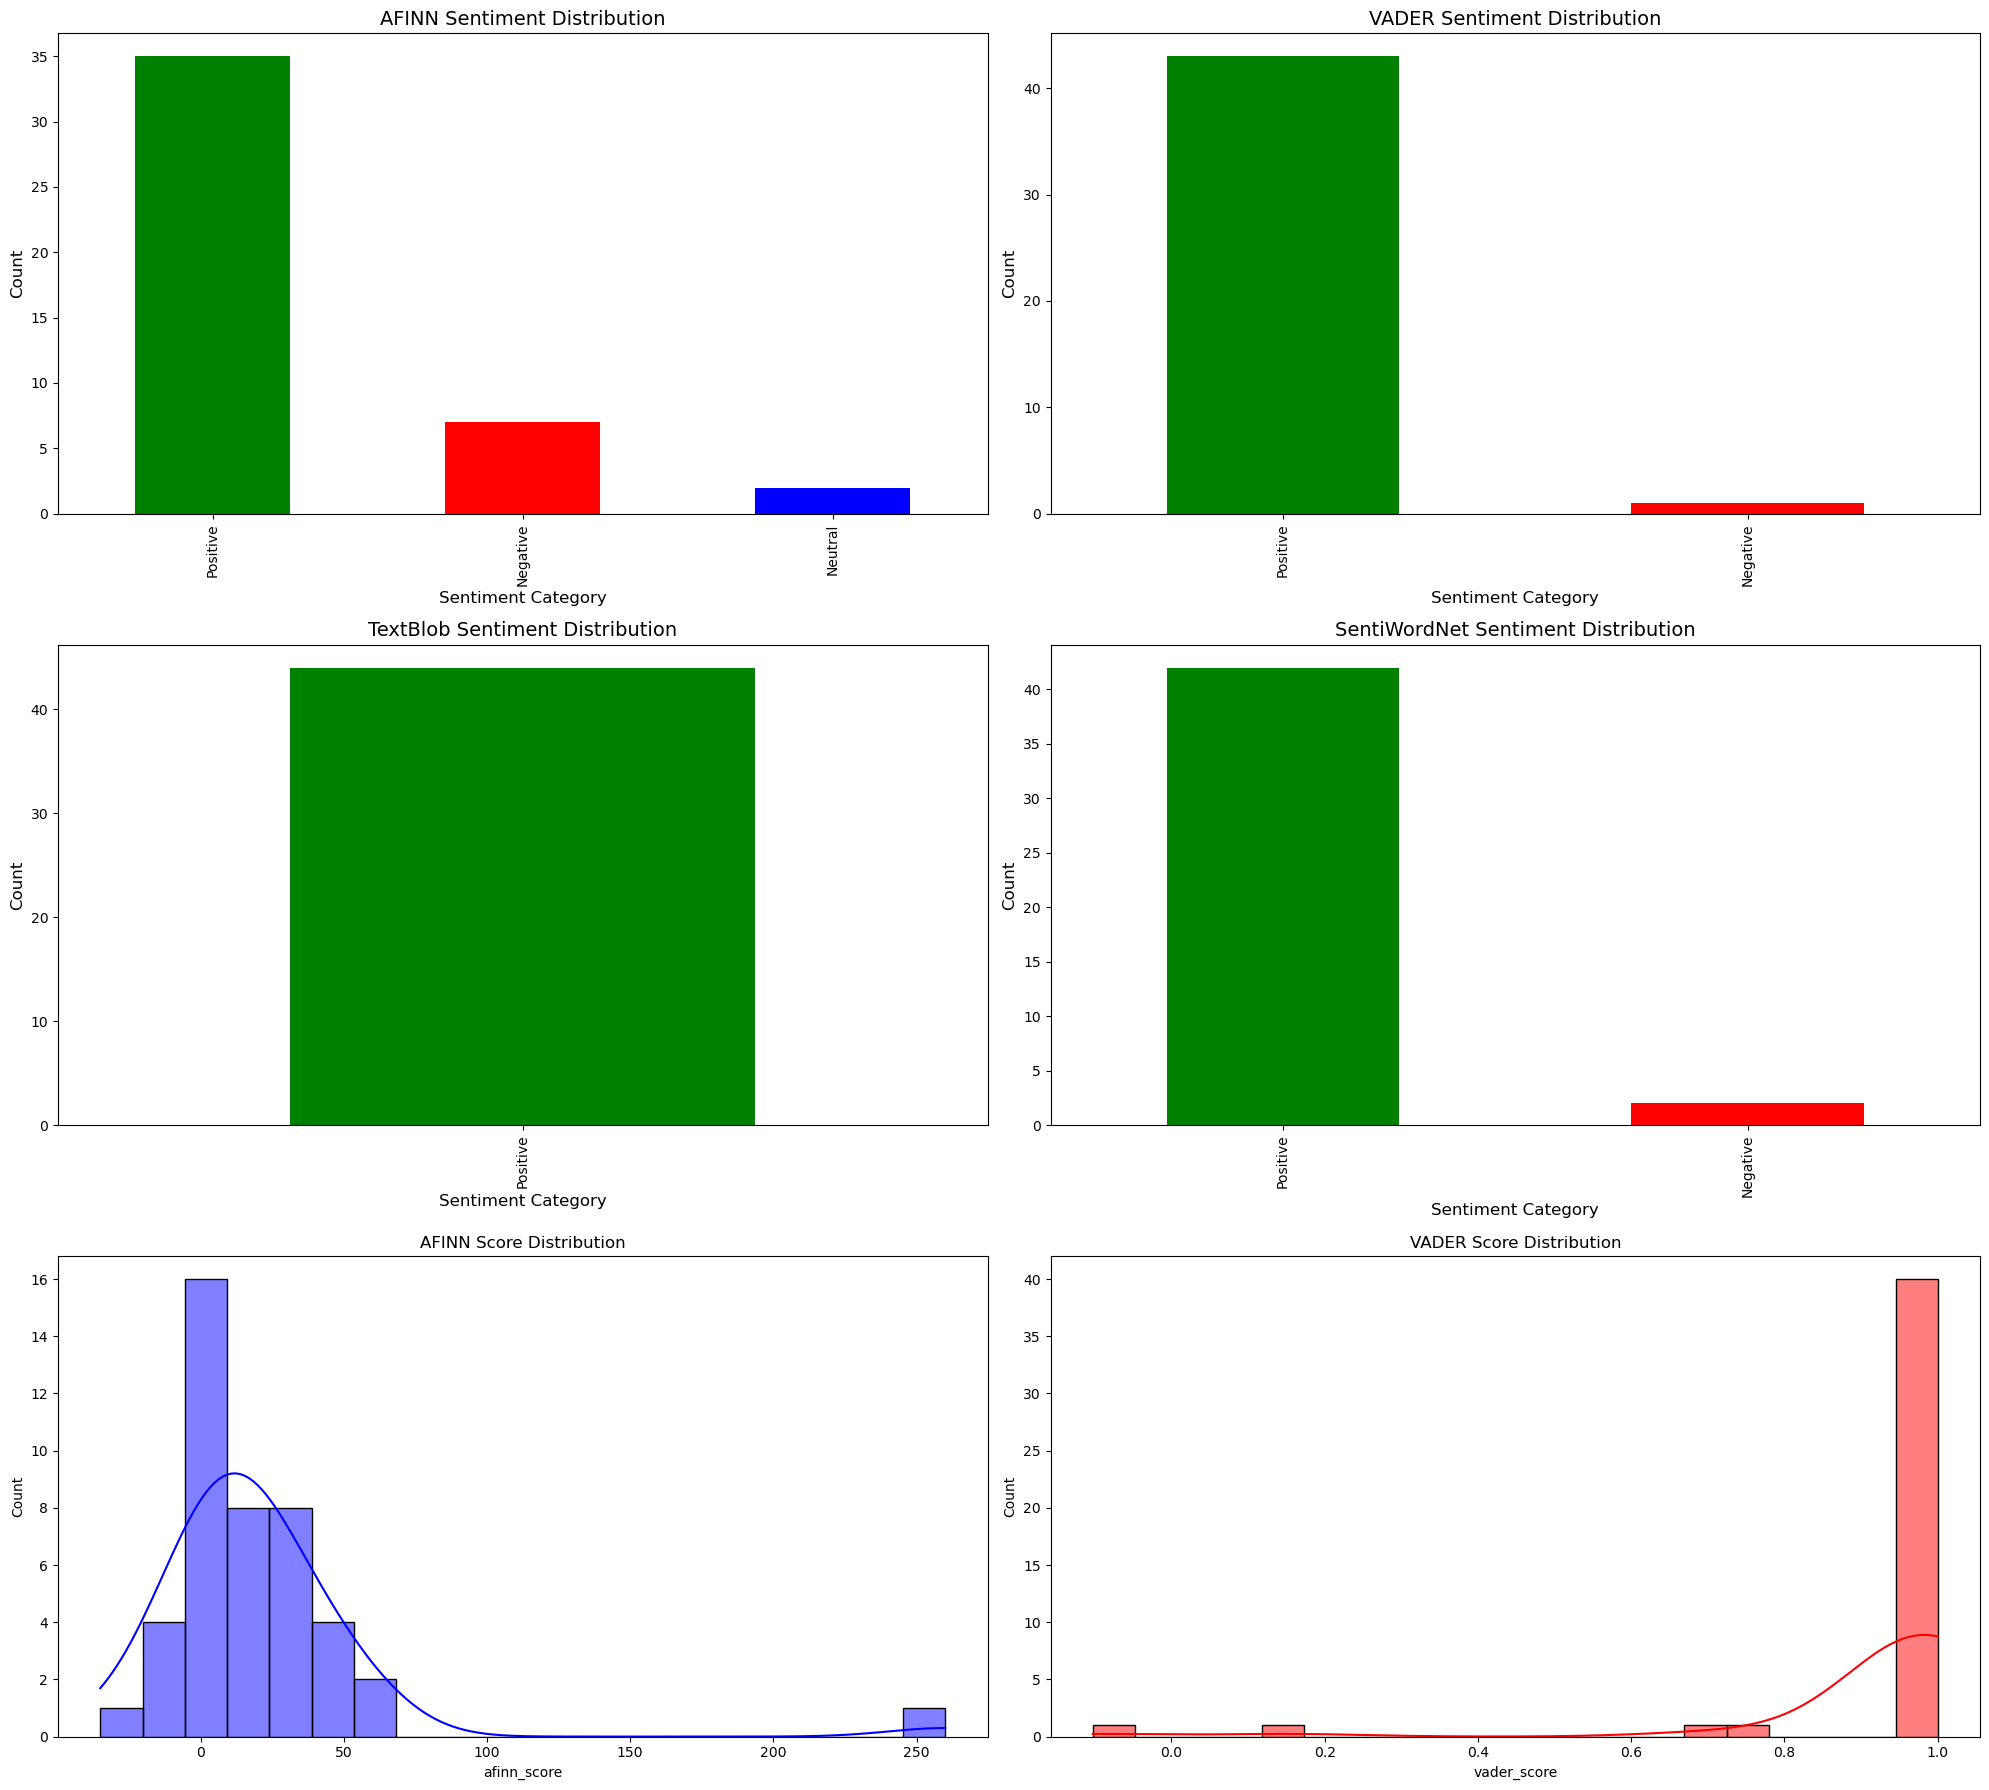

In [9]:
# Plot Sentiment Distributions
fig, axes = plt.subplots(3, 2, figsize=(20, 18))  # Adjusted for more plots
axes = axes.flatten()

for ax, method, category_col in zip(axes[:4], 
                                    ['AFINN', 'VADER', 'TextBlob', 'SentiWordNet'], 
                                    ['afinn_category', 'vader_category', 'textblob_category', 'sentiwordnet_category']):
    df[category_col].value_counts().plot(kind='bar', ax=ax, color=['green', 'red', 'blue'])
    ax.set_title(f'{method} Sentiment Distribution', fontsize=14)
    ax.set_xlabel('Sentiment Category', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

# Additional plots
sns.histplot(df['afinn_score'], kde=True, bins=20, ax=axes[4], color='blue')
axes[4].set_title("AFINN Score Distribution")

sns.histplot(df['vader_score'], kde=True, bins=20, ax=axes[5], color='red')
axes[5].set_title("VADER Score Distribution")

plt.tight_layout()
plt.show()

# Conclusion

## Sentiment Analysis Techniques Comparison
| Method        | Best For                     | Pros                      | Cons                         |
|--------------|-----------------------------|---------------------------|------------------------------|
| **AFINN**    | General sentiment analysis  | Simple, fast              | No context understanding     |
| **VADER**    | Social media, short text    | Handles slang, emojis     | Not ideal for long text      |
| **TextBlob** | Long text, simple analysis  | Easy to use               | Can be inaccurate            |
| **SentiWordNet** | Linguistic word-based analysis | More granular sentiment scores | Requires word tokenization |

## Additional Techniques
- **Latent Dirichlet Allocation (LDA)**: Used for **topic modeling**, helps to extract hidden topics in text.
- **Summarization**: Extractive/abstractive approaches to **summarize** large text data, improving readability.